Self-RAG

Self-RAG는 검색된 문서와 생성된 응답 모두에 대해 점검하고 검증하는 추가 단계를 포함하는 RAG 전략입니다.
전통적인 RAG에서는 검색된 정보를 기반으로 LLM이 답변을 생성하는 것이 주된 과정이었다면, Self-RAG에서는 자체 평가를 통해 다음과 같은 사항을 검증합니다.

- 검색할 필요성 판단: 현재 질문에 대해 추가 검색이 필요한지 여부를 판단합니다.
- 검색 결과 관련성 평가: 검색된 문서 조각(청크)이 질문 해결에 도움이 되는지 확인합니다.
- 응답 사실성 검증: 생성된 답변이 제공된 문서 청크에 의해 충분히 뒷받침되는지 평가합니다.
- 응답 품질 평가: 생성된 답변이 실제로 질문을 잘 해결하는지 측정합니다.

이 과정을 통해 단순히 검색하고 답변을 생성하는 단계를 넘어, 생성된 응답의 품질과 사실성을 스스로 모니터링하고 향상시킬 수 있습니다.

이 튜토리얼에서 다룰 내용

- Retriever: 문서를 검색
- Retrieval Grader: 검색된 문서의 관련성 평가
- Generate: 질문에 대한 답변 생성
- Hallucination Grader: 생성된 답변의 사실성(환각 여부) 검증
- Answer Grader: 답변의 질문에 대한 관련성 평가
- Question Re-writer: 쿼리 재작성
- 그래프 생성 및 실행: 정의한 노드로 그래프를 빌드하고 실행


In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")


LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


기본 PDF 기반 Retrieval Chain 생성


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.document_loaders import PyPDFLoader
from langchain_community.embeddings import OllamaEmbeddings

# PDF 파일 로드. 파일의 경로 입력
loader = PyPDFLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")

# 텍스트 분할기를 사용하여 문서를 분할합니다.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# 문서를 로드하고 분할합니다.
split_docs = loader.load_and_split(text_splitter)

# VectorStore를 생성합니다.
ollama_embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    # model="chatfire/bge-m3:q8_0" # BGE-M3
)
vector = Chroma.from_documents(
    documents=split_docs, embedding=ollama_embeddings, collection_name="my_db"
)


# Retriever를 생성합니다.
pdf_retriever = vector.as_retriever()


/var/folders/5d/4yvbq7s16359fdr947szsx5h0000gn/T/ipykernel_13599/1447049240.py:16: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(


문서 검색 평가기 (Retrieval Grader)
- 추후 retrieve 노드에서 문서에 대한 관련성 평가를 진행하기 위해 미리 정의합니다.



In [3]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs


# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
)

# GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader


In [7]:
# 질문 정의
question = "삼성전자가 개발한 생성형 AI 의 이름은?"

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 두 번째 문서의 페이지 콘텐츠 추출
doc_txt = docs[1].page_content

# 검색 평가기 호출 및 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


답변 생성 체인
- 답변 생성 체인은 검색된 문서를 기반으로 답변을 생성하는 체인입니다.



In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# LangChain Hub에서 프롬프트 가져오기
prompt = hub.pull("teddynote/rag-prompt")

# 기본 LLM 초기화, 모델 이름과 온도 설정
lllm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

# 체인 실행
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)


AI(systems)안전의 중요한 원칙 및 지침은 다음과 같은 몇 가지 요소를 포함している다.

1.  시스템의 위험을 최소화하고 안전함을 보장하는 방식
2.  시스템의 개발, 시행, 유지에 대한 정보 제공
3.  시스템Safety에 관련된 평가와 оцен Procedure(예: 안전평가)

AI (Artificial Intelligence) 시스템과 비기존(Systems, e.g., computer programs), human and society의 Interactions에서 사용 occurs. 그리고 AIs는 일반적으로 system에 의해서 작동합니다.
 
1. AIs는 system 과 관련된 risks, risk assessment, risk mitigation strategy development 및 use, safety control plan development 및 use 등에 대한 정보와 지침을 provide한다.
2. AIs의 safety requirements and consideration are discussed below:

*   Human oversight and review is used to validate AI decision-making
*   Regular testing for potential failures and bias in performance
*   Review of existing regulations such as ECG, FDA, HIPAA
*   Compliance with industry standards such as NIST Cybersecurity Framework
*   Collaboration on security assessments to provide a better understanding of the system's potential vulnerabilities.
 
AI의 특성과 그 가치에 대한 논의는 다음과 같은 몇 가지 요소를 포함합니다.

1.  AIs가 human-like abil

답변의 할루시네이션 여부를 평가

groundedness_grader 를 생성하고 생성된 답변과 context 를 기반하여 답변의 할루시네이션 평가를 진행합니다.

yes 인 경우 답변의 할루시네이션이 없을을 의미합니다. 반대로, no 인 경우 답변이 할루시네이션으라고 간주합니다.

In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델 정의: 생성된 답변이 사실에 기반하고 있는지 여부를 이진 점수로 평가하기 위한 데이터 모델
class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    # 답변이 사실에 기반하고 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 초기화
lllm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

# 구조화된 출력과 함께 LLM 설정
structured_llm_grader = llm.with_structured_output(Groundednesss)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 채팅 프롬프트 템플릿 생성
groundedness_checking_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 답변의 할루시네이션 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_llm_grader


In [10]:
# 할루시네이션 평가기 호출(yes: 사실에 기반하고 있음, no: 사실에 기반하고 있지 않음)
groundedness_grader.invoke({"documents": format_docs(docs), "generation": generation})


Groundednesss(binary_score=':[{')

답변의 관련성 평가

생성된 답변이 질문(question)과의 관련성 있는 답변인지 여부를 평가합니다.

yes인 경우는 관련성 있음. no인 경우는 관련성 없음을 의미합니다.

In [11]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    # 답변의 관련성 평가: 'yes' 또는 'no'로 표기(yes: 관련성 있음, no: 관련성 없음)
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


lllm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

# llm 에 GradeAnswer 바인딩
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 생성
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 답변 평가기 생성
answer_grader = answer_grader_prompt | structured_llm_grader

In [12]:
# 답변 평가기 호출(yes: 질문을 해결함, no: 질문을 해결하지 않음)
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

질문 재작성기(Question Rewriter)

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


lllm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

# 시스템 프롬프트 정의
# 입력 질문을 벡터스토어 검색에 최적화된 형태로 변환하는 시스템 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 시스템 메시지와 초기 질문을 포함한 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문 재작성기 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [14]:
# 질문 재작성기 호출
question_rewriter.invoke({"question": question})

'The original question asks about a specific type of AI, Genesis AI.\n\nI can improve this question by adding more context or details that may help me understand what you are looking for. Here\'s a revised version:\n\n "What is the name of Samsung\'s Genesis-type artificial intelligence (AI) system that...?"\n\nOr, if I wanted to ask further questions about the technology behind it, I could try:\n\n"What type of AI does Samsung claim its Genesis system utilizes? Is it deep learning-based, neural network-driven, or something else entirely?"\n"In what sense is the Samsung Genesis system similar to, or distinct from, established AI frameworks and technologies?"\n\nThese revised questions aim to be more open-ended and informative, allowing me to better understand the intent behind your query.'

상태(State) 정의

- question: 사용자가 입력한 질문
- generation: 생성된 응답
- documents: 검색된 문서 목록

In [15]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 클래스 정의
class GraphState(TypedDict):
    # 질문을 나타내는 문자열
    question: Annotated[str, "Question"]
    # LLM에 의해 생성된 응답을 나타내는 문자열
    generation: Annotated[str, "LLM Generation"]
    # 문서의 목록을 나타내는 문자열 리스트
    documents: Annotated[List[str], "Retrieved Documents"]


노드 정의

- retrieve: 문서 검색
- grade_documents: 문서 평가
- generate: 답변 생성
- transform_query: 질문 재작성

In [16]:
# 문서 검색
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성
def generate(state):
    print("==== [GENERATE] ====")
    question = state["question"]
    documents = state["documents"]

    # RAG 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 검색된 문서의 관련성 평가
def grade_documents(state):
    print("==== [GRADE DOCUMENTS] ====")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("==== GRADE: DOCUMENT RELEVANT ====")
            filtered_docs.append(d)
        else:
            print("==== GRADE: DOCUMENT NOT RELEVANT ====")
            continue
    return {"documents": filtered_docs}


# 질문 변환
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


조건부 엣지 정의

decide_to_generate 함수는 검색된 문서의 관련성 평가 결과에 따라 답변 생성 여부를 결정합니다.

grade_generation_v_documents_and_question 함수는 생성된 답변의 문서 및 질문과의 관련성 평가 결과에 따라 답변 생성 여부를 결정합니다.

In [17]:
# 답변 생성 여부 결정
def decide_to_generate(state):
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성이 없는 경우
        # 새로운 쿼리 생성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# 생성된 답변의 문서 및 질문과의 관련성 평가
def grade_generation_v_documents_and_question(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = groundedness_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # 질문 해결 여부 확인
        print("==== [GRADE GENERATION vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("==== [DECISION: GENERATION ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATION DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"


그래프 생성

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# 엣지 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 엣지 정의
workflow.add_edge("transform_query", "retrieve")

# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)

# 시작점 설정  
workflow.set_entry_point("retrieve")

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

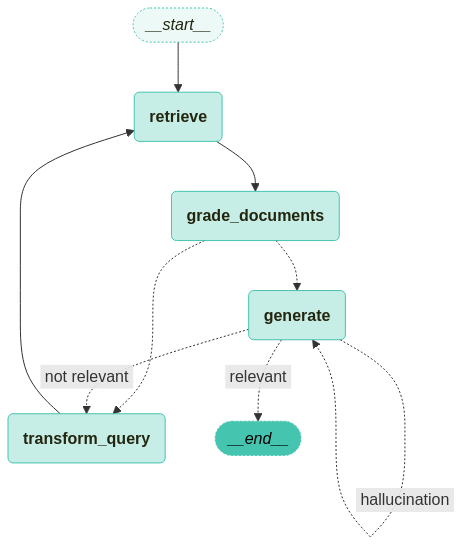

In [26]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

그래프 실행

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
invoke_graph(
    app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
)

==== [RETRIEVE] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='SPRi AI Brief |  
2023-12 월호
2G7, 히로시마 AI 프로세스를 통해 AI 기업 대상 국제 행동강령에 합의
nG7이 첨단 AI 시스템을 개발하는 기업을 대상으로 AI 위험 식별과 완화를 위해 자발적인 
채택을 권고하는 AI 국제 행동강령을 마련
n행동강령은 AI 수명주기 전반에 걸친 위험 평가와 완화, 투명성과 책임성의 보장, 정보공유와 
이해관계자 간 협력, 보안 통제, 콘텐츠 인증과 출처 확인 등의 조치를 요구KEY Contents
£G7, 첨단 AI 시스템의 위험 관리를 위한 국제 행동강령 마련
n주요 7개국(G7)* 은 2023 년 10월 30일 ‘히로시마 AI 프로세스 ’를 통해 AI 기업 대상의 AI 국제 
행동강령 (International Code of Conduct for Advanced AI Systems) 에 합의
∙G7은 2023 년 5월 일본 히로시마에서 개최된 정상회의에서 생성 AI에 관한 국제규범 마련과 
정보공유를 위해 ‘히로시마 AI 프로세스 ’를 출범**
∙기업의 자발적 채택을 위해 마련된 이번 행동강령은 기반모델과 생성 AI를 포함한 첨단 AI 시스템의 
위험 식별과 완화에 필요한 조치를 포함
* 주요 7개국(G7)은 미국, 일본, 독일, 영국, 프랑스 , 이탈리아 , 캐나다를 의미
** 5월 정상회의에는 한국, 호주, 베트남 등을 포함한 8개국이 초청을 받았으나 , AI 국제 행동강령에는 우선 G7 국가만 포함하여 채택
nG7은 행동강령을 통해 아래의 조치를 제시했으며 , 빠르게 발전하는 기술에 대응할 수 있도록 
이해관계자 협의를 통해 필요에 따라 개정할 예정
∙첨단 AI 시스템의 개발 과정에서 AI 수명주기 전반에 걸쳐 위험을 평가 및 완화하는 조치를 채택하고 , 
첨단 AI 시스템의 출시와 배포 이후 취약점과 오

In [ ]:
from langgraph.errors import GraphRecursionError

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "코봉이가 개발한 생성형 AI 의 이름은?",
}

try:
    # 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
        ["retrieve", "transform_query", "grade_documents", "generate"],
    )
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")
